# L1. Dead Reckoning 

### Define all the imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
pd.set_option('mode.chained_assignment', None)

In [3]:
from src.localization.dead_reckoning import DeadReckoning

### Load a dataset

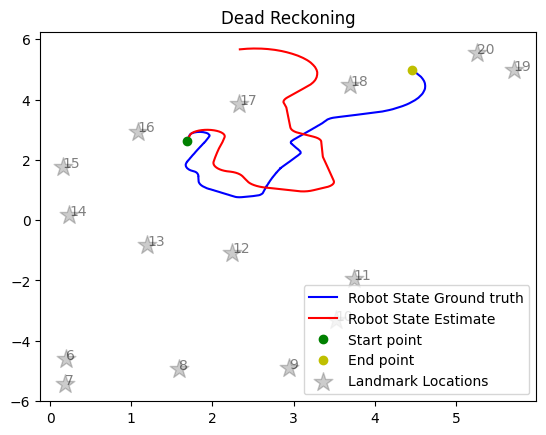

In [4]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset2" # Dataset
end_frame = 10000 # Extension of the dataset
robot = 'Robot3' # Robot

# Build dead reckoning object
self = DeadReckoning(dataset, robot, end_frame)
self.run()

### TASK 1. Inspect the dataset
The objective of this task is to understand how the control inputs used to estimate the robots localization may differ from the actual robot motion.

Go through the following blocks of code while understanding what the different functions do. Add a markdown block after each block of code explaining what its being done, and add titles and legends to the plots to demonstrate your understanding.

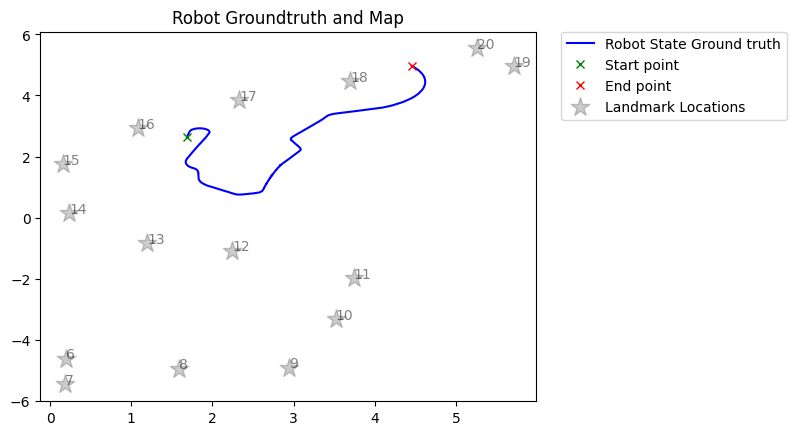

In [5]:
# Build dataframes
self.build_dataframes()

# Represent dataset
self.represent_dataset()

##### Plot linear and angular velocity commands
This is the data we use as an input of our motion model

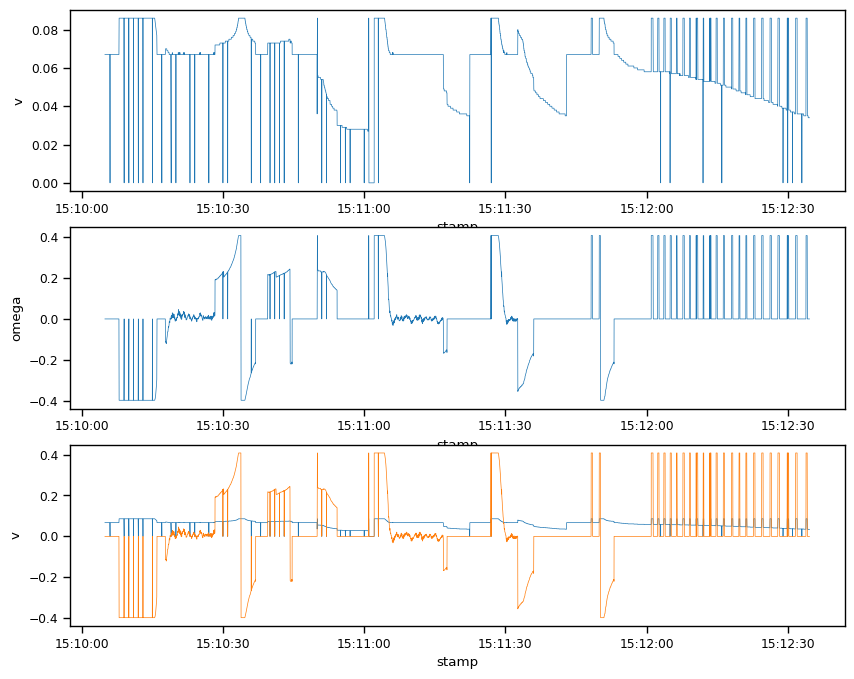

In [6]:
sns.set_context("paper")
fig, axs = plt.subplots(3, 1, figsize=[10,8])
sns.lineplot(data=self.motion, x="stamp", y="v", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion, x="stamp", y="omega", ax=axs[1], linewidth=0.5)
sns.lineplot(data=self.motion, x="stamp", y="v", ax=axs[2], linewidth=0.5)
sns.lineplot(data=self.motion, x="stamp", y="omega", ax=axs[2], linewidth=0.5)
plt.show()

##### Compare with groundtruth

In [7]:
# Generate groundtruth speeds from GT for comparison
self.motion_gt = self.motion.join(self.gt).dropna()
self.motion_gt['dx'] = self.motion_gt['x'].diff()
self.motion_gt['dy'] = self.motion_gt['y'].diff()
self.motion_gt['dtheta'] = self.motion_gt['theta'].diff()
self.motion_gt['dt'] = self.motion_gt.index.to_series().diff().dt.total_seconds()
self.motion_gt['v_gt'] = np.linalg.norm([self.motion_gt['dx'],self.motion_gt['dy']],axis=0)/self.motion_gt['dt']
self.motion_gt['omega_gt'] = self.motion_gt['dtheta']/self.motion_gt['dt']
self.motion_gt.head()

,type,v,omega,x,y,theta,dx,dy,dtheta,dt,v_gt,omega_gt
stamp,,,,,,,,,,,,
2009-07-22 15:10:08.379000064,-1.0,0.086,-0.398,1.721801,2.831794,1.2653,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-22 15:10:11.008999936,-1.0,0.000,0.000,1.805327,2.920559,0.2314,0.083527,0.088766,-1.0339,2.630,0.046344,-0.393118
2009-07-22 15:10:11.172000000,-1.0,0.086,-0.398,1.813401,2.922999,0.1640,0.008074,0.002439,-0.0674,0.163,0.051743,-0.413497
2009-07-22 15:10:16.634000128,-1.0,0.067,0.000,1.956318,2.756269,-1.8605,0.142917,-0.166729,-2.0245,5.462,0.040205,-0.370652
2009-07-22 15:10:18.412000000,-1.0,0.068,-0.041,1.922942,2.639079,-1.8981,-0.033375,-0.117190,-0.0376,1.778,0.068532,-0.021147


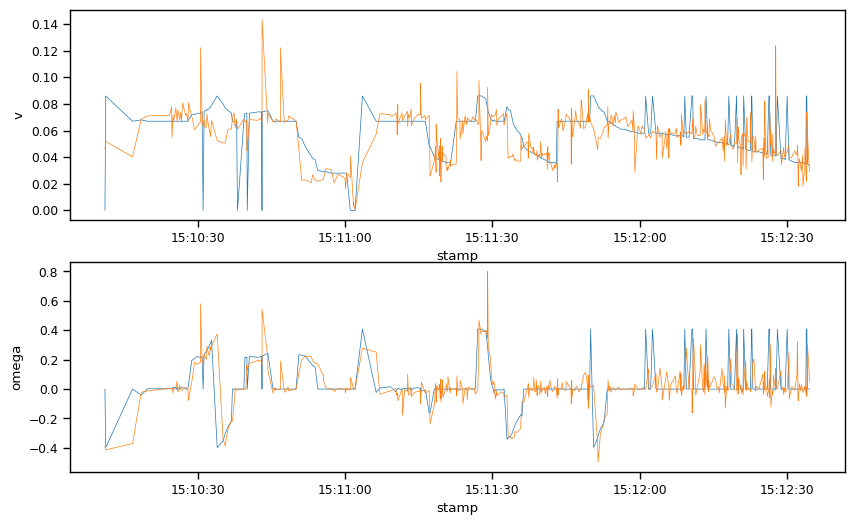

In [8]:
# Plot commands and GT velocities
self.motion_gt = self.motion_gt.dropna()
fig, axs = plt.subplots(2, 1, figsize=[10,6])
sns.lineplot(data=self.motion_gt, x="stamp", y="v", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="v_gt", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="omega", ax=axs[1], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="omega_gt", ax=axs[1], linewidth=0.5)
plt.show()

<AxesSubplot:xlabel='stamp', ylabel='omega_e'>

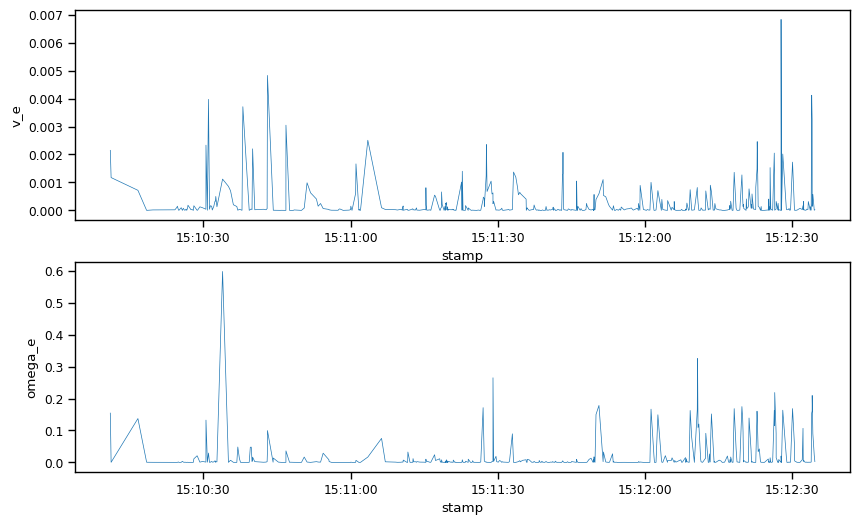

In [9]:
# Get error
self.motion_gt['v_e'] = np.power(self.motion_gt['v_gt'] - self.motion_gt['v'],2)
self.motion_gt['omega_e'] =  np.power(self.motion_gt['omega_gt'] - self.motion_gt['omega'],2)

fig, axs = plt.subplots(2, 1, figsize=[10,6])
sns.lineplot(data=self.motion_gt, x="stamp", y="v_e", ax=axs[0], linewidth=0.5)
sns.lineplot(data=self.motion_gt, x="stamp", y="omega_e", ax=axs[1], linewidth=0.5)


### TASK 2. Estimate localization with dead reckoning

The objective of this task is getting a localization estimate by dead reckoning, and compare the obtained result with the groundtruth using three different error metrics.

Please review what the self.run() function does this is the function we executed at the begining of the notebook. Then postproces the obtained estimation and analize the quality of it. 

In [10]:
self.measurements.head()

,type,range_l,bearing_l
stamp,,,
2009-07-22 15:10:04.938999808,-1.0,0.067,0.0
2009-07-22 15:10:04.980000000,-1.0,0.067,0.0
2009-07-22 15:10:05.010999808,-1.0,0.067,0.0
2009-07-22 15:10:05.030999808,-1.0,0.067,0.0
2009-07-22 15:10:05.040999936,-1.0,0.067,0.0


In [11]:
self.states.head()

,x,y,theta
stamp,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.3663
2009-07-22 15:10:04.938999808,1.683707,2.629446,1.3663
2009-07-22 15:10:04.980000000,1.684264,2.632135,1.3663
2009-07-22 15:10:05.010999808,1.684686,2.634169,1.3663
2009-07-22 15:10:05.030999808,1.684958,2.635481,1.3663


In [12]:
self.gt.head()

,x,y,theta
stamp,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.3663
2009-07-22 15:10:04.966000128,1.683418,2.628294,1.3663
2009-07-22 15:10:05.000000000,1.683385,2.628285,1.3663
2009-07-22 15:10:05.020999936,1.683394,2.628222,1.3663
2009-07-22 15:10:05.025000192,1.683424,2.628215,1.3663


In [13]:
data = self.states.join(self.gt,rsuffix='_gt').dropna()
data.head()

,x,y,theta,x_gt,y_gt,theta_gt
stamp,,,,,,
2009-07-22 15:10:04.920999936,1.683462,2.628265,1.366300,1.683462,2.628265,1.3663
2009-07-22 15:10:08.379000064,1.735027,2.860235,1.180434,1.721801,2.831794,1.2653
2009-07-22 15:10:11.008999936,1.894577,2.992075,0.181852,1.805327,2.920559,0.2314
2009-07-22 15:10:11.172000000,1.908418,2.994280,0.116978,1.813401,2.922999,0.1640
2009-07-22 15:10:16.634000128,2.142412,2.702252,-1.721803,1.956318,2.756269,-1.8605


#### Absolute Trajectory Error (ATE)


### TASK 3. Iterate over diferent datasets
Here we are interested on executing multiple experiments using different robots and datasets and get the three error metrics from previous blocks for all the experiments and enable further analisis of this errors.

The iterative execution of different experiments will enable as to compare different localization algorithms on further lab sessions.

#### Generate metrics

In [14]:
datasets = ["../data/MRCLAM_Dataset1",
            "../data/MRCLAM_Dataset2",
            "../data/MRCLAM_Dataset3",
            "../data/MRCLAM_Dataset4"]
robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

errors = pd.DataFrame(columns=['dataset','robot','ate'])

#for ds in datasets:
   #for rob in robots:
        # Load data
        
        # Get the error

#### Represent metrics

In [15]:
# Represent metrics for all experiments

#### Analize metrics

In [16]:
# Analize the results and provide the mean error metrics across the experiments performed.